# 피마 인디언 당뇨병 예측
피마 인디언 당뇨병 (Pima Indian Diabetes) 데이터 세트를 이용해  
당뇨병 여부를 판단하는 머신러닝 예측 모델을 수립하고  
지금까지 학습한 오차행렬, 정확도, 정밀도, 재현율, F1 스코어, ROC AUC 평가 지표 적용  

**피마 인디언 당뇨병 데이터 세트**  
북아메리카 피마 지역 원주민의 Type-2 당뇨병 결과 데이터  
보통 당뇨 원인은 식습관과 유전을 꼽음  
피마 지역은 고립된 지역에서 인디언 고유의 혈통이 지속되어 왔지만  
20세기 후반에 들어서면서 서구화된 식습관으로 많은 당뇨 환자 발생  
고립된 유전적 특성 때문에 당뇨 학회에서는 피마 인디언 당뇨병 자료에 많은 연구를 함

**피마 인디언 당뇨병 데이터 세트 피처 구성**  
- Pregnancies : 임신 횟수
- Glucose : 포도당 부하 검사 수치
- BloodPressure : 혈압 (mm Hg)
- SkinThickness : 팔 삼두근 뒤쪽의 피하지방 측정값
- Insulin : 혈청 인슐린
- BMI : 체질량 지수
- DiabetesPedigreeFunction : 당뇨 내력 가중치 값
- age : 나이
- Outcome : 클래스 결정 값 (0 또는 1)

## 라이브러리 불러오기

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve
from sklearn.preprocessing import StandardScaler, Binarizer
from sklearn.linear_model import LogisticRegression

## 데이터 불러오기

In [43]:
diabetes_data = pd.read_csv('data/diabetes.csv')
print(diabetes_data['Outcome'].value_counts())
diabetes_data.head(5)

0    500
1    268
Name: Outcome, dtype: int64


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


전체 768개의 데이터 중 Positive 값 (1)이 268개, Negative(0) 값이 500개로 구성되어 있음

In [44]:
# diabetes 데이터 갼략히 보기(feature type 및 Null 값 개수 보기)
diabetes_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


Null 값은 존재하지 않으며 모두 int, float의 숫자형 데이터이므로  
Null 값과 문자열 처리를 위한 별도의 작업은 필요하지 않음  

#### 앞으로 할 일
- 로지스틱 회귀를 이용해 예측 모델 생성  
- 데이터 세트를 피처 데이터와 클래스 데이터 세트로 나누고 학습 데이터 세트와 테스트 세트로 분리
- 로지스틱 회귀를 이용해 예측 수행
- 성능 평가 지표 출력
- 재현율 곡선 시각화

## 로지스틱 회귀를 이용한 예측모델 생성

### 평가 지표 함수 설정

In [45]:
# 앞 예제에서 get_clf_eval()과 precision_recall_curve_plot()을 추가해서 사용

# 평가지표 출력하는 함수 설정
def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix(y_test, pred) # 오차행렬
    accuracy = accuracy_score(y_test, pred)    # 정확도
    precision = precision_score(y_test, pred) # 정밀도
    recall = recall_score(y_test, pred)        # 재현율
    f1 = f1_score(y_test, pred)               # F1 스코어 
    roc_auc = roc_auc_score(y_test, pred_proba)  # ROC-AUC  
    
    print("오차 행렬")
    print(confusion)
    print('정확도 : {0:.4f}, 정밀도: {1:.4f}, 재현율 : {2:.4f},\
    F1 : {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

### 정밀도 재현율 곡선 함수 설정

In [46]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

def precision_recall_curve_plot(y_test, pred_proba_c1) :
    # threshold ndarray 와 이 threshold에 따른 정밀도, 재현율 ndarray 추출
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)
    
    # X축을 threshold값으로, Y축은 정밀도, 재현율 값으로 각각 Plot 수행, 정밀도는 점선으로 표시
    plt.figure(figsize=(8, 6))
    threshold_boundary = thresholds.shape[0]  # (143, 0)에서 143 추출
    
    # thresholds는 143이고, precisions과 recalls는 144로 X축과 Y축 값의 개수가 맞지 않으므로
    # precisions과 recalls로 그래프를 그리면 오류가 남..
    # y값을 [0:threshold_boundary]로 143개 추출해서 X축 개수와 맞춤
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle = '--', label = 'precision')
    plt.plot(thresholds, recalls[0:threshold_boundary], label = 'recall')   
    
    # threshold 값 X 축의 Scale을 0.1 단위로 변경
    # xlim() : X 축 범위를 지정하거나 반환
    start, end = plt.xlim()  # X축 범위 반환
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))
    
    # X축, Y축 label과 legend, 그리고 grid 설정
    plt.xlabel('Threshold value')
    plt.ylabel('Precision and Recall value')
    plt.legend()
    plt.grid()
    plt.show()

### LogisticRegression으로 학습/예측 수행

In [50]:
# LogisticRegression으로 학습/예측 수행

# 데이터 추출
# 피처 데이터 세트 : X
# 레이블 데이터 세트 : y
X = diabetes_data.iloc[:, :-1] # 슬라이싱 start에서 end -1까지
y = diabetes_data.iloc[:, -1]   # 인덱싱 : 마지막 칼럼

# 학습 데이터 세트와 테스트 데이터 세트로 분리

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=156, stratify=y)

# 로지스틱 회귀로 학습/예측/평가 수행
lr_clf = LogisticRegression(solver='liblinear')
lr_clf.fit(X_train, y_train)
pred = lr_clf.predict(X_test)

# 예측 확률 
pred_proba = lr_clf.predict_proba(X_test)[:, 1]

get_clf_eval(y_test, pred, pred_proba)

오차 행렬
[[87 13]
 [22 32]]
정확도 : 0.7727, 정밀도: 0.7111, 재현율 : 0.5926,    F1 : 0.6465, AUC:0.8083


**결과**  
예측 정확도가 77.27% 이고 재현율이 59.26% 로 측정됨  
전체 데이터의 약 65%가 Negative이므로 정확도 보다는 재현율 성능에 초첨을 맞춰보겠음  
먼저 정밀도 재현율 곡선을 보고 임곗값별 정밀도와 재현율 값의 변화를 확인해보겠음  

#### 피마 인디언 당뇨병 데이터 세트
- 전체 768개 중에서 1이 268개 : 34.89 %
- stratify=y로 설정한 경우 (비율 거의 유사)
    - 학습 데이터 세트 에서 1의 비율 : 34.85 %
    - 데스트 데이터 세트에서 1의 비율 : 35.06%
- stratify=y로 설정하지 않은 경우 (비율 차이가 있음)
    - 학습 데이터 세트 에서 1의 비율 : 34.36 %
    - 데스트 데이터 세트에서 1의 비율 : 37.01 %

### 임계값별로 정밀도-재현율 출력

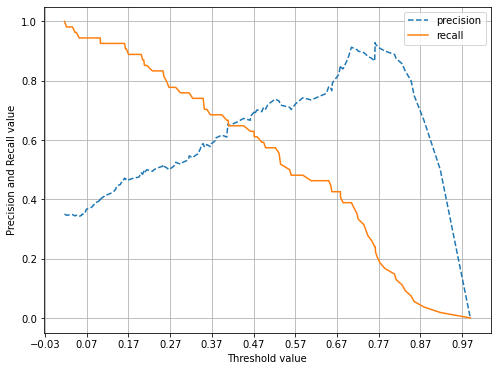

In [49]:
# 임계값별로 정밀도-재현율 출력
pred_proba = lr_clf.predict_proba(X_test)[:, 1]
precision_recall_curve_plot(y_test, pred_proba)

**결과**  
재현율 곡선을 보면 임곗값을 0.42정도로 낮추면 정밀도와 재현율이 어느 정도 균형을 맞춤  
하지만 두 개 지표 모두 0.7이 안되는 수준으로 높지 않음  
데이터를 다시 확인해서 개선할 부분이 있는지 확인해 보자  

In [51]:
# 데이터의 기초 통계값들
diabetes_data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


데이터값을 보면 최소값이 0으로 되어있는 값이 많음  
Glucose(당 수치), BloodPressure(혈압), SkinThickness(피하지방), Insulin(인슐린), BMI(체질량 지수) 같은 값이  
실제로 0일 수는 없다고 생각되므로 확인이 필요함  

## 데이터 세트에서 0값 확인해서 평균으로 대체하기
### 데이터 세트에서 0값 그래프 그리기

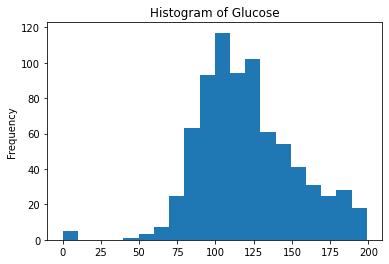

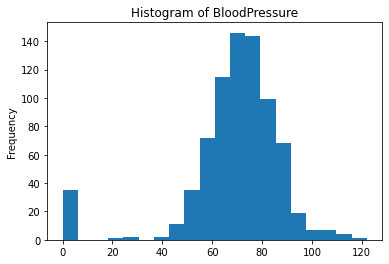

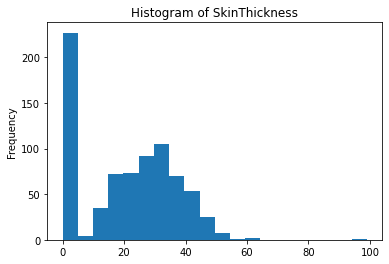

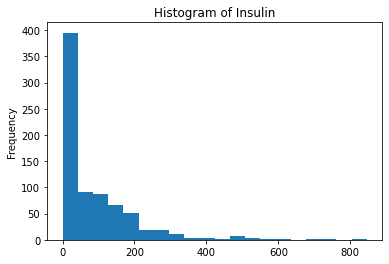

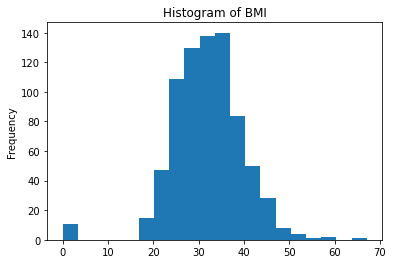

In [53]:
# 0값이 얼마나 있는지 그래프로 확인
feature_list = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

def hist_plot(df):
    for col in feature_list:
        df[col].plot(kind='hist', bins=20).set_title('Histogram of '+col)
        plt.show()

hist_plot(diabetes_data)

### 데이터 세트에서 0값의 비율 확인
전체 데이터 건수 대비 0값이 몇 퍼센트 비율인지 확인하기

In [56]:
# 0값을 검사할 피처 명 리스트
zero_features = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

# 전체 데이터 건수
total_count = diabetes_data['Glucose'].count()

# 피처별로 반복하면서 데이터 값이 0인 데이터 건수를 추출하고, 퍼센트 계산
for feature in zero_features :
    zero_count = diabetes_data[diabetes_data[feature] == 0][feature].count()
    print('{0} 0 건수는 {1}, 퍼센트는 {2:.2f}%'.format(feature, zero_count, 100*zero_count/total_count))

Glucose 0 건수는 5, 퍼센트는 0.65%
BloodPressure 0 건수는 35, 퍼센트는 4.56%
SkinThickness 0 건수는 227, 퍼센트는 29.56%
Insulin 0 건수는 374, 퍼센트는 48.70%
BMI 0 건수는 11, 퍼센트는 1.43%


SkinThickness와 Insulin의 경우 0 값의 비율이 각각 29.56%, 48.70%로 상당히 높음   
이들 데이터를 삭제하기에는 너무 많으므로 피처 0 값을 평균 값으로 대체  

### 데이터 세트에서 0값 평균으로 대체하기
StandardScaler 클래스를 이용해서 피처 데이터 세트에 일괄적으로 스케일링을 적용하고  
0값을 평균으로 대체한 데이터 세트로 학습/예측 수행

In [64]:
# zero_features 리스트 내부에 저장된 개별 피처들에 대해서 0값을 평균 값으로 대체
mean_zero_features = diabetes_data[zero_features].mean()
diabetes_data[zero_features] = diabetes_data[zero_features].replace(0, mean_zero_features)

## 바뀐 데이터 세트로 로지스틱 회귀를 이용한 예측모델 생성

In [66]:
# LogisticRegression으로 학습/예측 수행

# 데이터 추출
# 피처 데이터 세트 : X
# 레이블 데이터 세트 : y
X = diabetes_data.iloc[:, :-1] # 슬라이싱 : start에서 end -1까지
y = diabetes_data.iloc[:, -1]  # 인덱싱 : 마지막 칼럼

# StandardScaler 클래스를 이용해서 피처 데이터 세트에 일괄적으로 스케일링 적용
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 학습 데이터 세트와 테스트 데이터 세트로 분리

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=156, stratify=y)

# 로지스틱 회귀로 학습/예측/평가 수행
lr_clf = LogisticRegression(solver='liblinear')
lr_clf.fit(X_train, y_train)
pred = lr_clf.predict(X_test)

# 예측 확률 
pred_proba = lr_clf.predict_proba(X_test)[:, 1]

get_clf_eval(y_test, pred, pred_proba)

오차 행렬
[[90 10]
 [21 33]]
정확도 : 0.7987, 정밀도: 0.7674, 재현율 : 0.6111,    F1 : 0.6804, AUC:0.8433


## 임계값 변화에 따른 예측 성능 확인

In [69]:
# 임계값에 따른 평가 수치 출력 함수
from sklearn.preprocessing import Binarizer

def get_eval_by_threshold(y_test, pred_proba_c1, thresholds):
    # thresholds 리스트 값을 차례로 반복하면서 평가 수행
    for custom_threshold in thresholds:
        binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_c1)
        custom_predict = binarizer.transform(pred_proba_c1)
        
        print('\n임계값 : ', custom_threshold)
        
        # 위에서 만든 평가 함수 호출
        get_clf_eval(y_test, custom_predict, pred_proba_c1)

In [71]:
# 임계값 변화에 따른 예측 성능 확인
thresholds = [0.3, 0.33, 0.36, 0.39, 0.42, 0.45, 0.48, 0.50]
pred_proba = lr_clf.predict_proba(X_test)
get_eval_by_threshold(y_test, pred_proba[:, 1].reshape(-1, 1), thresholds)


임계값 :  0.3
오차 행렬
[[65 35]
 [11 43]]
정확도 : 0.7013, 정밀도: 0.5513, 재현율 : 0.7963,    F1 : 0.6515, AUC:0.8433

임계값 :  0.33
오차 행렬
[[71 29]
 [11 43]]
정확도 : 0.7403, 정밀도: 0.5972, 재현율 : 0.7963,    F1 : 0.6825, AUC:0.8433

임계값 :  0.36
오차 행렬
[[76 24]
 [15 39]]
정확도 : 0.7468, 정밀도: 0.6190, 재현율 : 0.7222,    F1 : 0.6667, AUC:0.8433

임계값 :  0.39
오차 행렬
[[78 22]
 [16 38]]
정확도 : 0.7532, 정밀도: 0.6333, 재현율 : 0.7037,    F1 : 0.6667, AUC:0.8433

임계값 :  0.42
오차 행렬
[[84 16]
 [18 36]]
정확도 : 0.7792, 정밀도: 0.6923, 재현율 : 0.6667,    F1 : 0.6792, AUC:0.8433

임계값 :  0.45
오차 행렬
[[85 15]
 [18 36]]
정확도 : 0.7857, 정밀도: 0.7059, 재현율 : 0.6667,    F1 : 0.6857, AUC:0.8433

임계값 :  0.48
오차 행렬
[[88 12]
 [19 35]]
정확도 : 0.7987, 정밀도: 0.7447, 재현율 : 0.6481,    F1 : 0.6931, AUC:0.8433

임계값 :  0.5
오차 행렬
[[90 10]
 [21 33]]
정확도 : 0.7987, 정밀도: 0.7674, 재현율 : 0.6111,    F1 : 0.6804, AUC:0.8433


**결과**  
정확도와 정밀도를 희생하고 재현율을 높이는데 가장 좋은 임계값은 0.3  
재현율 : 0.7963 이지만 정밀도가 0.5513 이므로 매우 낮음 > 극단적인 선택으로 보임  
  
임계값이 0.48일 경우  
정확도 : 0.7987, 정밀도가 0.7447, 재현율이 0.6481  
F1스코어 : 0.6931, ROC AUC : 0.84333 으로  
전체적인 성능 평가 지표를 유지하면서 재현율을 약간 향상시키는 좋은 임계값으로 보임  

In [74]:
# 임계값을 0.48로 설정하여 예측 수행
binarizer = Binarizer(threshold=0.48)

# 위에서 구한 predict_proba() 예측확률의 array에서 1에 해당하는 컬럼 값을 대입하여 Binarizer 반환하기
pred_th_048 = binarizer.fit_transform(pred_proba[:, 1].reshape(-1, 1))

get_clf_eval(y_test, pred_th_048, pred_proba[:,1])

오차 행렬
[[88 12]
 [19 35]]
정확도 : 0.7987, 정밀도: 0.7447, 재현율 : 0.6481,    F1 : 0.6931, AUC:0.8433
